# SENTIMETION CLASSIFICATION WITH UIT-VSFC DATASET

## Importing the libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from tqdm import tqdm
import time


## Dataset

In [20]:
X_train = pd.read_csv('UIT-VSFC/train/feedback.txt', sep=' \n', engine='python', header=None, names=['feedback'])
y_train =  pd.read_csv('UIT-VSFC/train/label.txt', sep=" \n", engine='python', header=None, names=['label'])

X_test = pd.read_csv('UIT-VSFC/test/feedback.txt', sep=' \n', engine='python', header=None, names=['feedback'])
y_test =  pd.read_csv('UIT-VSFC/test/label.txt', sep=" \n", engine='python', header=None, names=['label'])


### Preview dataset

In [21]:
X_train

,feedback
0,slide giáo trình đầy đủ .
1,"nhiệt tình giảng dạy , gần gũi với sinh viên ."
2,đi học đầy đủ full điểm chuyên cần .
3,chưa áp dụng công nghệ thông tin và các thiết ...
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng..."
...,...
13004,hướng dẫn lab mơ hồ .
13005,thầy cho chúng em những bài tập mang tính thực...
13006,thầy không dạy nhiều chủ yếu cho sinh viên tự ...
13007,em muốn đổi tên môn học vì tên môn là lập trìn...


In [22]:
y_train.value_counts()

label
2        6448
0        6030
1         531
dtype: int64

In [23]:
y_test.value_counts()

label
2        1590
0        1409
1         167
dtype: int64

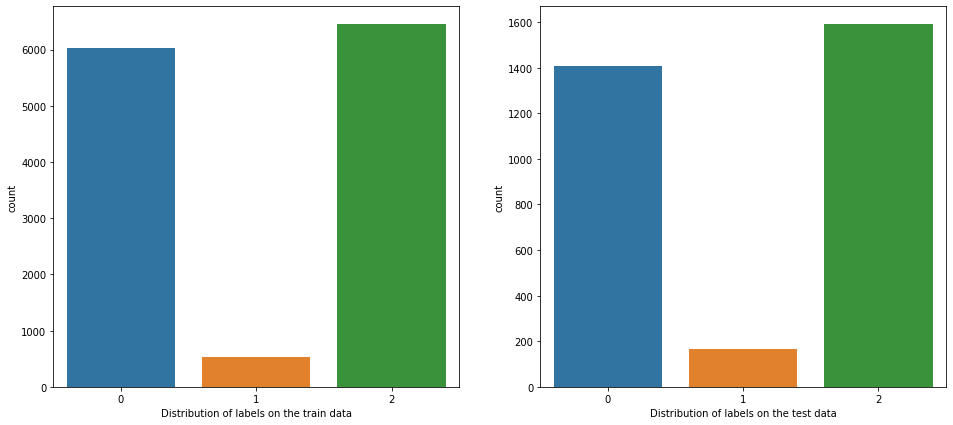

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
sns.countplot(data=y_train, x='label', ax=ax1)
sns.countplot(data=y_test, x='label', ax=ax2)
ax1.set_xlabel('Distribution of labels on the train data')
ax2.set_xlabel('Distribution of labels on the test data')
plt.show()

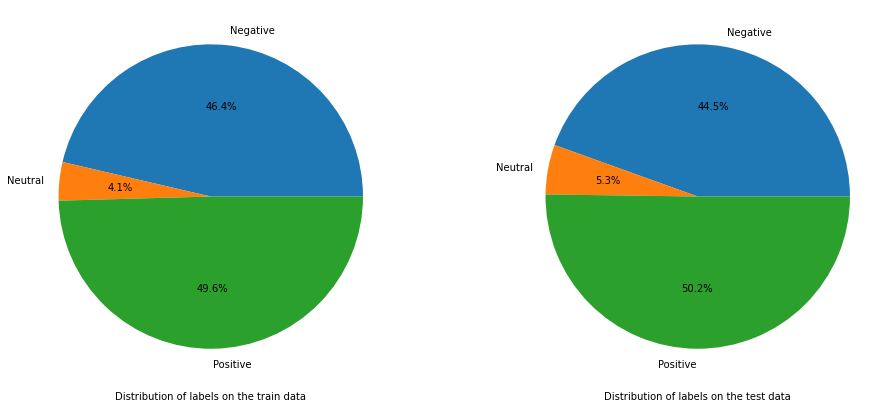

In [25]:
labels = ['Negative', 'Neutral', 'Positive']
data1 = y_train.value_counts(sort=False)
data2 = y_test.value_counts(sort=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
ax1.pie(data1, labels = labels, autopct='%1.1f%%')
ax2.pie(data2, labels = labels, autopct='%1.1f%%')
ax1.set_xlabel('Distribution of labels on the train data')
ax2.set_xlabel('Distribution of labels on the test data')
plt.show()

## Preprocessing

In [26]:
import re
def Preprocessing(feedback):
    # xóa ký tự kéo dài 
    feedback = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), feedback, flags=re.I)

    # chuẩn hóa chữ thường
    feedback = feedback.lower()

    # xóa ký hiệu teencode
    icons = [':)', ':(', '@@', '<3', ':d', ':3', ':v', ':_', ':p', '>>', ':">', '^^', 'v.v', ':B', ':^', ':v', 'y_y', 'u_u']
    for icon in icons:
        feedback = feedback.replace(icon,' ')
        
    # xóa từ viết tắt mà tác giả đã biến đổi
    acronyms = ['colon', 'smile', 'sad', 'surprise', 'love', 'contemn', 'big', 'smile', 'cc', 
                'small', 'hihi', 'double', 'vdotv','dot', 'fraction', 'csharp']
    for acronym in acronyms:
        feedback = feedback.replace(acronym, ' ')
    
    # xóa ký tự đặc biệt
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for punc in punctuation:
        feedback = feedback.replace(punc,' ') 

    # ViTokenize tách từ
    feedback = ViTokenizer.tokenize(feedback)
    
    return feedback

In [27]:
for i in tqdm(range(len(X_train['feedback']))):
    X_train['feedback'][i] = Preprocessing(X_train['feedback'][i])

100%|██████████| 13009/13009 [00:06<00:00, 2014.09it/s]


In [28]:
for i in tqdm(range(len(X_test['feedback']))):
    X_test['feedback'][i] = Preprocessing(X_test['feedback'][i])

100%|██████████| 3166/3166 [00:02<00:00, 1575.02it/s]


In [29]:
X_train

,feedback
0,slide giáo_trình đầy_đủ
1,nhiệt_tình giảng_dạy gần_gũi với sinh_viên
2,đi học đầy_đủ ful điểm chuyên_cần
3,chưa áp_dụng công_nghệ thông_tin và các thiết_...
4,thầy giảng bài hay có nhiều bài_tập ví_dụ ngay...
...,...
13004,hướng_dẫn lab mơ_hồ
13005,thầy cho chúng em những bài_tập mang tính thực...
13006,thầy không dạy nhiều chủ_yếu cho sinh_viên tự ...
13007,em muốn đổi tên môn_học vì tên môn là lập_trìn...


In [30]:
y_train

,label
0,2
1,2
2,0
3,0
4,2
...,...
13004,0
13005,2
13006,0
13007,0


# TfidfVectorizer

In [31]:
tfidf = TfidfVectorizer(ngram_range=(1,1), use_idf=False, norm=None, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train['feedback'])
X_test_tfidf= tfidf.transform(X_test['feedback'])

y_train_tfidf = y_train['label']
y_test_tfidf = y_test['label']

In [45]:
print(len(tfidf.get_feature_names_out()))

3887


# SMOTE tăng cường dữ liệu tập train

In [33]:
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(k_neighbors=7, random_state=42, kind='borderline-2')    
X_train_tfidf, y_train_tfidf = smote.fit_resample(X_train_tfidf, y_train_tfidf)

In [34]:
metrics = []

# Naive Bayes Model

In [35]:
NB_model = MultinomialNB(alpha=10)
NB_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = NB_model.predict(X_test_tfidf)

print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8209    0.8978    0.8576      1409
           1     0.2812    0.3234    0.3008       167
           2     0.9267    0.8352    0.8786      1590

    accuracy                         0.8361      3166
   macro avg     0.6763    0.6855    0.6790      3166
weighted avg     0.8456    0.8361    0.8388      3166



# Logistic Regression

In [36]:
LR_model = LogisticRegression(multi_class='multinomial', C=10, penalty='l2', solver='lbfgs', max_iter=1000, random_state=42, tol=0.5)
LR_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = LR_model.predict(X_test_tfidf) 

print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8972    0.8552    0.8757      1409
           1     0.2673    0.5090    0.3505       167
           2     0.9269    0.8774    0.9015      1590

    accuracy                         0.8481      3166
   macro avg     0.6972    0.7472    0.7092      3166
weighted avg     0.8789    0.8481    0.8609      3166



# XG_Boost Model

In [37]:
XGB_model = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
XGB_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = XGB_model.predict(X_test_tfidf) 

print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8867    0.9219    0.9040      1409
           1     0.4480    0.3353    0.3836       167
           2     0.9112    0.9031    0.9071      1590

    accuracy                         0.8816      3166
   macro avg     0.7486    0.7201    0.7316      3166
weighted avg     0.8758    0.8816    0.8781      3166



# SVM Model

In [38]:
# SVM Model use Countvectorizer
SVM_model = SVC(C=10, gamma=0.1, kernel='rbf', random_state=42)
SVM_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = SVM_model.predict(X_test_tfidf) 

print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8803    0.9446    0.9113      1409
           1     0.5037    0.4072    0.4503       167
           2     0.9348    0.8931    0.9135      1590

    accuracy                         0.8904      3166
   macro avg     0.7729    0.7483    0.7584      3166
weighted avg     0.8878    0.8904    0.8881      3166



In [265]:
pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-score'], index=['Naive Bayes', 'Extreme Gradient Boosting', 'Logistic Regression', 'Support Vector Machine'])

,Precision,Recall,F1-score
Naive Bayes,0.676291,0.685458,0.679020
Extreme Gradient Boosting,0.748619,0.720135,0.731556
Logistic Regression,0.697150,0.747186,0.709232
Support Vector Machine,0.772940,0.748303,0.758380


In [39]:
from sklearn.ensemble import VotingClassifier
SVM_model.probability=True
voting_clf = VotingClassifier(estimators=[('xgb',XGB_model), ('lr',LR_model), ('svm',SVM_model)], voting='soft',weights=[0.32961080777070156,0.32759792453168607,0.3427912676976124])
voting_clf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = voting_clf.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_pred_tfidf, digits=4))
precision = precision_score(y_test_tfidf, y_pred_tfidf, average='macro')
recall = recall_score(y_test_tfidf, y_pred_tfidf, average='macro')
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
metrics.append([precision, recall, f1])

              precision    recall  f1-score   support

           0     0.8974    0.9432    0.9197      1409
           1     0.4762    0.4192    0.4459       167
           2     0.9376    0.9069    0.9220      1590

    accuracy                         0.8973      3166
   macro avg     0.7704    0.7564    0.7625      3166
weighted avg     0.8953    0.8973    0.8959      3166



In [40]:
pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-score'], index=['Naive Bayes', 'Extreme Gradient Boosting', 'Logistic Regression', 'Support Vector Machine', 'VotingClassifier'])

,Precision,Recall,F1-score
Naive Bayes,0.676291,0.685458,0.679020
Extreme Gradient Boosting,0.697150,0.747186,0.709232
Logistic Regression,0.748619,0.720135,0.731556
Support Vector Machine,0.772940,0.748303,0.758380
VotingClassifier,0.770379,0.756434,0.762526


In [41]:
print(len(tfidf.get_feature_names_out()))

3887


In [46]:
import joblib
joblib.dump((voting_clf, tfidf), 'model.h5')

['model.h5']